In [1]:
import os
import json
from datasets import load_dataset
import spacy
import wikipedia as wiki
from collections import Counter
from tqdm.auto import tqdm
import numpy as np
from matplotlib import pyplot as plt
from langchain.text_splitter import RecursiveCharacterTextSplitter
from transformers import AutoTokenizer

DATA_RAW_PATH = "../data/raw"
DATA_INTERIM_PATH = "../data/interim"
DATA_PROCESSED_PATH = "../data/processed"
WIKIPEDIA_ARTICLES_PATH = os.path.join(DATA_RAW_PATH, "wikipedia_articles")

os.makedirs(DATA_INTERIM_PATH, exist_ok=True)
os.makedirs(DATA_PROCESSED_PATH, exist_ok=True)
os.makedirs(WIKIPEDIA_ARTICLES_PATH, exist_ok=True)

NQ_SAMPLE_SIZE = 1000
WIKI_ARTICLE_TARGET_COUNT = 1000
TOP_N_ENTITIES_TO_CONSIDER = 350
MIN_ARTICLES_PER_ENTITY = 1
MAX_ARTICLES_PER_ENTITY = 20

In [2]:
print("Started loading NQ")

nq_dataset = load_dataset("sentence-transformers/natural-questions", split="train")
print(f"Loaded NQ dataset. Length: {len(nq_dataset)}")

print("\nExp[0]:")
print(nq_dataset[0])
print("-" * 50)

# set seed to allow result reproduction
nq_dataset_shuffled = nq_dataset.shuffle(seed=42)
nq_sample = nq_dataset_shuffled.select(range(NQ_SAMPLE_SIZE))

query_data = []
for item in tqdm(nq_sample, desc="Processing NQ"):
    if item["query"].strip():
        query_data.append(
            {
                "id": f"nq_{len(query_data)}",  # adding ID
                "query": item["query"],  # keep as it is
                "answer": item["answer"],  # keep as it is
            }
        )


nq_output_path = os.path.join(DATA_INTERIM_PATH, f"nq_questions_{NQ_SAMPLE_SIZE}.jsonl")
with open(nq_output_path, "w", encoding="utf-8") as f:
    for q_data in query_data:
        f.write(json.dumps(q_data) + "\n")

print(f"Saved {len(query_data)} questions to {nq_output_path}")

Started loading NQ
Loaded NQ dataset. Length: 100231

Exp[0]:
{'query': 'when did richmond last play in a preliminary final', 'answer': "Richmond Football Club Richmond began 2017 with 5 straight wins, a feat it had not achieved since 1995. A series of close losses hampered the Tigers throughout the middle of the season, including a 5-point loss to the Western Bulldogs, 2-point loss to Fremantle, and a 3-point loss to the Giants. Richmond ended the season strongly with convincing victories over Fremantle and St Kilda in the final two rounds, elevating the club to 3rd on the ladder. Richmond's first final of the season against the Cats at the MCG attracted a record qualifying final crowd of 95,028; the Tigers won by 51 points. Having advanced to the first preliminary finals for the first time since 2001, Richmond defeated Greater Western Sydney by 36 points in front of a crowd of 94,258 to progress to the Grand Final against Adelaide, their first Grand Final appearance since 1982. The a

Processing NQ:   0%|          | 0/1000 [00:00<?, ?it/s]

Saved 1000 questions to ../data/interim/nq_questions_1000.jsonl


In [ ]:
print("\nStarted feature extraction from NQ...")

try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    spacy.cli.download("en_core_web_sm")
    nlp = spacy.load("en_core_web_sm")

all_entities_texts = []
RELEVANT_ENTITY_TYPES = {
    "PERSON",
    "NORP",
    "FAC",
    "ORG",
    "GPE",
    "LOC",
    "PRODUCT",
    "EVENT",
    "WORK_OF_ART",
    "LAW",
    "LANGUAGE",
}
print(f"Using entities types: {RELEVANT_ENTITY_TYPES}")

for q_data in tqdm(query_data, desc="Entities processing"):
    doc = nlp(q_data["query"])
    for ent in doc.ents:
        if ent.label_ in RELEVANT_ENTITY_TYPES:
            entity_text = ent.text.strip()

            # entities pre-processing
            if entity_text.lower().startswith("the "):  # cut off 'the' prefix
                entity_text = entity_text[4:]
            if entity_text.endswith("'s"):
                entity_text = entity_text[:-2]  # cut off 's suffix

            if len(entity_text) > 2:  # select longer entities
                all_entities_texts.append(entity_text)

print(f"Got {len(all_entities_texts)} entities (with repetitions).")

# count entities frequency to check how many artiles shoud be found for particualr entity
# more popular entities should have bigger impact on selecting articles
# distribute artiles amount using frequency ensuring min and max number of artiles per entity
# we want to get aprox 1k articles
entity_counts_all = Counter(all_entities_texts)
most_common_entities_with_counts = entity_counts_all.most_common(TOP_N_ENTITIES_TO_CONSIDER)

if not most_common_entities_with_counts:
    print("ERROR: no entities after processing")
    raise Exception

print(f"\nTop 10 popular entities:")
for entity, count in most_common_entities_with_counts[:10]:
    print(f"- {entity}: {count}")

final_articles_per_entity = {}
articles_assigned_so_far = 0
temp_assigned_for_min = {}

# assgin minimum amount of articles to each entity
for entity_text, _ in most_common_entities_with_counts:
    if articles_assigned_so_far + MIN_ARTICLES_PER_ENTITY <= WIKI_ARTICLE_TARGET_COUNT:
        articles_assigned_so_far += MIN_ARTICLES_PER_ENTITY
        temp_assigned_for_min[entity_text] = MIN_ARTICLES_PER_ENTITY
    else:
        temp_assigned_for_min[entity_text] = 0

print(
    f"After assigning minimum ({MIN_ARTICLES_PER_ENTITY}), assigned {articles_assigned_so_far} articles to {len([v for v in temp_assigned_for_min.values() if v > 0])} encji."
)

remaining_articles_to_assign = WIKI_ARTICLE_TARGET_COUNT - articles_assigned_so_far

if remaining_articles_to_assign > 0:
    print(
        f"{remaining_articles_to_assign} articles left to be distributed (with limit {MAX_ARTICLES_PER_ENTITY})."
    )

    total_counts_for_proportion = sum(count for _, count in most_common_entities_with_counts)

    if total_counts_for_proportion > 0:
        proportional_assignment_additional = {}
        for entity_text, original_count in most_common_entities_with_counts:
            proportion = original_count / total_counts_for_proportion
            num_additional_ideal = proportion * remaining_articles_to_assign
            proportional_assignment_additional[entity_text] = num_additional_ideal

        sorted_by_ideal_additional = sorted(
            proportional_assignment_additional.items(), key=lambda item: item[1], reverse=True
        )

        for entity_text, ideal_add_val in sorted_by_ideal_additional:
            base_assigned_count = temp_assigned_for_min.get(entity_text, 0)
            can_still_get = MAX_ARTICLES_PER_ENTITY - base_assigned_count

            actual_additional_to_add = round(min(ideal_add_val, max(0, can_still_get)))
            final_articles_per_entity[entity_text] = base_assigned_count + actual_additional_to_add

        for entity_text, base_val in temp_assigned_for_min.items():
            if entity_text not in final_articles_per_entity:
                final_articles_per_entity[entity_text] = base_val

    else:
        final_articles_per_entity = temp_assigned_for_min.copy()

else:
    final_articles_per_entity = temp_assigned_for_min.copy()

final_articles_per_entity = {k: v for k, v in final_articles_per_entity.items() if v > 0}

sorted_final_articles_list = sorted(
    final_articles_per_entity.items(), key=lambda item: item[1], reverse=True
)
final_articles_per_entity = dict(sorted_final_articles_list)

total_assigned_final_softmax = sum(final_articles_per_entity.values())
print(
    f"Total number of articles to download: {total_assigned_final_softmax} (target: {WIKI_ARTICLE_TARGET_COUNT})"
)


Started feature extraction from NQ...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 29.4 MB/s eta 0:00:00a 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
Using entities types: {'NORP', 'PRODUCT', 'EVENT', 'WORK_OF_ART', 'LAW', 'PERSON', 'LANGUAGE', 'FAC', 'ORG', 'GPE', 'LOC'}


Entities processing:   0%|          | 0/1000 [00:00<?, ?it/s]

Got 324 entities (with repetitions).

Top 10 popular entities:
- united states: 11
- india: 9
- american: 9
- british: 7
- english: 6
- france: 6
- china: 6
- french: 6
- texas: 6
- america: 5
After assigning minimum (1), assigned 207 articles to 207 encji.
793 articles left to be distributed (with limit 20).
Total number of downloaded articles: 915 (target: 1000)



 Distribution of articles for top 40 enities (in total 207 enitites):


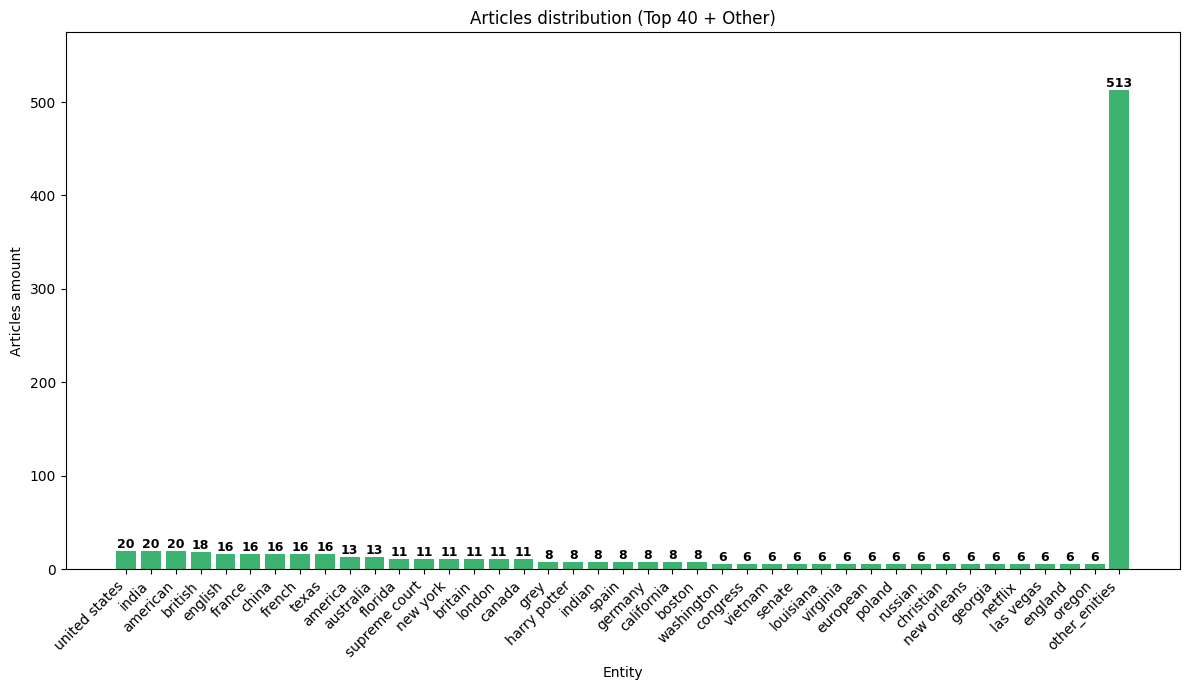

In [4]:
# this cell is for visualisation purposes only

print(
    f"\n Distribution of articles for top 40 enities (in total {len(final_articles_per_entity)} enitites):"
)
total_assigned_final_softmax = sum(final_articles_per_entity.values())

num_top_entities_to_show_individually = 40

entities_for_plot = []
article_counts_for_plot = []

items_for_individual_plot = list(final_articles_per_entity.items())[
    :num_top_entities_to_show_individually
]

for entity, num_docs in items_for_individual_plot:
    entities_for_plot.append(entity)
    article_counts_for_plot.append(num_docs)

# calculate sum for other entities (out of top 10)
num_articles_in_top_shown = sum(article_counts_for_plot)
num_articles_other = total_assigned_final_softmax - num_articles_in_top_shown
entities_for_plot.append("other_enities")
article_counts_for_plot.append(num_articles_other)


plt.figure(figsize=(12, 7))
bars = plt.bar(entities_for_plot, article_counts_for_plot, color="mediumseagreen")
plt.xlabel("Entity")
plt.ylabel("Articles amount")
plt.title(f"Articles distribution (Top {num_top_entities_to_show_individually} + Other)")
plt.xticks(rotation=45, ha="right", fontsize=10)

for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2.0,
        yval,
        f"{int(yval)}",
        va="bottom",
        ha="center",
        color="black",
        fontweight="bold",
        fontsize=9,
    )

plt.ylim(0, max(article_counts_for_plot) * 1.12)
plt.tight_layout()
plt.show()

In [5]:
wiki.set_lang("en")
wiki.set_user_agent(
    "MyRAGProject/1.0 (https://github.com/Kapturz0ny/rag-wiki; marcin.bagnowski@o2.pl)"
)
print("'wikipedia' configured")

print("\nStarting downloading articles")

downloaded_articles_map = {}
downloaded_titles_set = set()  # to avoid duplicates

MIN_ARTICLE_LENGTH = 300

articles_pbar = tqdm(total=WIKI_ARTICLE_TARGET_COUNT, desc="Downloading articles")

entities_to_process_ordered = [
    entity for entity, _ in most_common_entities_with_counts if entity in final_articles_per_entity
]

for entity_text in tqdm(entities_to_process_ordered, desc="Processing entities"):
    if len(downloaded_articles_map) >= WIKI_ARTICLE_TARGET_COUNT:
        print(f"Finished")
        break

    num_articles_to_fetch_for_entity = final_articles_per_entity.get(entity_text, 0)
    if num_articles_to_fetch_for_entity == 0:
        continue

    # increase a limit a little as some artiles might duplicate or something...
    search_limit = max(
        num_articles_to_fetch_for_entity + 2, int(num_articles_to_fetch_for_entity * 1.5)
    )

    try:
        # this gives top-k (serach_limit) artiles titles found for given entity
        search_results_titles = wiki.search(entity_text, results=search_limit)
    except Exception as e:
        print(f"Error while search for '{entity_text}': {e}")
        search_results_titles = []

    articles_found_for_this_entity = 0
    for page_title_from_search in search_results_titles:
        if len(downloaded_articles_map) >= WIKI_ARTICLE_TARGET_COUNT:
            break
        if articles_found_for_this_entity >= num_articles_to_fetch_for_entity:
            break

        normalized_search_title = page_title_from_search.lower()
        if normalized_search_title in downloaded_titles_set:
            continue

        try:
            # returns page for given title
            page_obj = wiki.page(page_title_from_search, auto_suggest=False, redirect=True)

            page_content = page_obj.content
            page_actual_title = page_obj.title

            if page_actual_title.lower() in downloaded_titles_set:
                continue

        except wiki.exceptions.PageError:
            # page not found
            continue
        except Exception as e:
            continue

        if page_content and len(page_content) > MIN_ARTICLE_LENGTH:
            if not isinstance(page_actual_title, str):  # save check
                continue

            sane_title = page_actual_title.replace("/", "_").replace("\\", "_")

            article_path = os.path.join(WIKIPEDIA_ARTICLES_PATH, f"{sane_title}.txt")
            try:
                with open(article_path, "w", encoding="utf-8") as f_art:
                    f_art.write(page_content)
            except Exception as e:
                print(f"Error saving article '{sane_title}': {e}")
                continue

            downloaded_articles_map[page_actual_title] = page_content
            downloaded_titles_set.add(page_actual_title.lower())
            downloaded_titles_set.add(normalized_search_title)

            articles_pbar.update(1)
            articles_pbar.set_postfix({"Downloaded": len(downloaded_articles_map)})
            articles_found_for_this_entity += 1
        else:
            if page_content and len(page_content) <= MIN_ARTICLE_LENGTH:
                print(
                    f"Article '{page_actual_title}' (for entity '{entity_text}') too short ({len(page_content)} chars)."
                )

articles_pbar.close()

print(f"Downloaded {len(downloaded_articles_map)} unique articles.")

wiki_corpus_output_path = os.path.join(
    DATA_INTERIM_PATH, f"wikipedia_corpus_{len(downloaded_articles_map)}.jsonl"
)
with open(wiki_corpus_output_path, "w", encoding="utf-8") as f:
    for idx, (title, text) in enumerate(
        tqdm(downloaded_articles_map.items(), desc="Saving Wiki corpus")
    ):
        f.write(json.dumps({"id": f"wiki_{idx}", "title": title, "text": text}) + "\n")
print(f"Saved corpus ({len(downloaded_articles_map)} articles) to {wiki_corpus_output_path}")

'wikipedia' configured

Starting downloading articles


Processing entities:   0%|          | 0/207 [00:00<?, ?it/s]

/home/mbagnows/studia/projekty/sem6/rag-wiki/.venv/lib/python3.12/site-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html.parser"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /home/mbagnows/studia/projekty/sem6/rag-wiki/.venv/lib/python3.12/site-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="html.parser"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


Downloaded 894 unique articles.


Saving Wiki corpus:   0%|          | 0/894 [00:00<?, ?it/s]

Saved corpus (894 articles) to ../data/interim/wikipedia_corpus_894.jsonl


In [ ]:
wiki_corpus_files = [
    f
    for f in os.listdir(DATA_INTERIM_PATH)
    if f.startswith("wikipedia_corpus_") and f.endswith(".jsonl")
]
if not wiki_corpus_files:
    raise FileNotFoundError(f"Not found wikipedia_corpus_*.jsonl in {DATA_INTERIM_PATH}")
WIKIPEDIA_CORPUS_PATH = os.path.join(
    DATA_INTERIM_PATH, sorted(wiki_corpus_files)[-1]
)  # Use the newest/biggest document
print(f"Used Wikipedia corpus file: {WIKIPEDIA_CORPUS_PATH}")

WIKIPEDIA_CHUNKS_PATH = os.path.join(DATA_PROCESSED_PATH, "wikipedia_chunks.jsonl")
RETRIEVER_TOKENIZER_NAME = (
    "BAAI/bge-large-en-v1.5"  # will be used to calculate lenght of the tokenized articles
)

try:
    tokenizer = AutoTokenizer.from_pretrained(RETRIEVER_TOKENIZER_NAME)
    print(f"Loaded tokenizer: {RETRIEVER_TOKENIZER_NAME}")

    def retriever_tokens_counter(text: str) -> int:
        return len(
            tokenizer.encode(text, add_special_tokens=False)
        )  # to don't count special tokens

    CHUNK_SIZE_TOKENS = 320  # Target lenght in tokens for bge-base-en-v1.5
    CHUNK_OVERLAP_TOKENS = 64  # Overlap size (in tokens)
    LENGTH_FUNCTION = retriever_tokens_counter

except Exception as e:
    raise SystemExit(f"Error loading tokenizer {RETRIEVER_TOKENIZER_NAME}")

# splitter init
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=CHUNK_SIZE_TOKENS,
    chunk_overlap=CHUNK_OVERLAP_TOKENS,
    length_function=LENGTH_FUNCTION,
    separators=["\n\n", "\n", ". ", "? ", "! ", ", ", " ", ""],
    keep_separator=False,
)

all_chunks_data = []
total_articles_processed = 0
total_chunks_created = 0

try:
    with open(WIKIPEDIA_CORPUS_PATH, "r", encoding="utf-8") as f_corpus:
        first_line = f_corpus.readline()
        if not first_line:
            raise ValueError(f"File {WIKIPEDIA_CORPUS_PATH} is empty.")

        # set cursor to file's beggining
        f_corpus.seek(0)

        article_lines = f_corpus.readlines()

    for line in tqdm(article_lines, desc="Processing articles"):
        try:
            article = json.loads(line)
            article_id = article.get("id", f"unknown_id_{total_articles_processed}")
            article_title = article.get("title", "Unknown Title")
            article_text = article.get("text", "")

            if not article_text.strip():
                continue

            raw_chunks = text_splitter.split_text(article_text)

            for i, chunk_text in enumerate(raw_chunks):
                cleaned_chunk_text = " ".join(chunk_text.split())
                if not cleaned_chunk_text or len(cleaned_chunk_text) < 30:
                    continue

                chunk_id = f"{article_id}_chunk_{i}"
                chunk_data = {
                    "passage_id": chunk_id,
                    "document_id": article_id,
                    "document_title": article_title,
                    "passage_text": cleaned_chunk_text,
                    "chunk_index": i,
                }
                all_chunks_data.append(chunk_data)
                total_chunks_created += 1

            total_articles_processed += 1
        except json.JSONDecodeError:
            print(f"Error decoding JSON in line: {line.strip()}")
        except Exception as e:
            print(
                f"Error processing article line ('{article_title if 'article_title' in locals() else 'N/A'}'): {e}"
            )

except ValueError as ve:
    print(str(ve))
except Exception as general_e:
    print(f"General error {general_e}")

print(f"\nProcessed {total_articles_processed} articles.")
print(f"Created {total_chunks_created} chunks.")
if total_articles_processed > 0:
    print(f"Avg {total_chunks_created / total_articles_processed:.2f} chunks per article.")

with open(WIKIPEDIA_CHUNKS_PATH, "w", encoding="utf-8") as f_chunks:
    for chunk_data in tqdm(all_chunks_data, desc="Saving chunks"):
        f_chunks.write(json.dumps(chunk_data) + "\n")

print(f"Saved {len(all_chunks_data)} chunks to {WIKIPEDIA_CHUNKS_PATH}")

Used Wikipedia corpus file: ../data/interim/wikipedia_corpus_961.jsonl
Loaded tokenizer: BAAI/bge-large-en-v1.5


Processing articles:   0%|          | 0/961 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (745 > 512). Running this sequence through the model will result in indexing errors



Processed 961 articles.
Created 36508 chunks.
Avg 37.99 chunks per article.


Saving chunks:   0%|          | 0/36508 [00:00<?, ?it/s]

Saved 36508 chunks to ../data/processed/wikipedia_chunks_bge_base.jsonl
